In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Data Preparation


###  loading the bikes dataset

In [2]:
df = pd.read_excel("biking_dataset.xlsx")
# cleaning the name of the columns, keep  every character as lower case and keeping only alpha numeric characters
df.columns = [''.join(ch.lower() for ch in column if ch.isalnum()) for column in df.columns]


### Size of the dataset

In [3]:
# the df.shape shows the number of rows and columns
# There are 900 rows and 8 columns
df.shape

(900, 8)

### Characterizing columns

In [4]:
df.columns

Index(['city', 'weathercondition', 'riderage', 'bikemodel', 'ridedurationmin',
       'distancecoveredkm', 'ridersatisfaction', 'bikerentalcost'],
      dtype='object')

In [5]:
df.dtypes

city                  object
weathercondition      object
riderage             float64
bikemodel             object
ridedurationmin      float64
distancecoveredkm    float64
ridersatisfaction     object
bikerentalcost       float64
dtype: object

| Column Name            | Data Type   | Description                                                                                     |
|------------------------|-------------|-------------------------------------------------------------------------------------------------|
| City                   | Categorical | The main city where the bike ride takes place. Possible values: "New York", "San Francisco", "Chicago", "London", "Berlin". |
| Weather Condition      | Categorical | Weather conditions during the bike ride. Possible values: "Sunny", "Rainy", "Cloudy", "Snowy".  |
| Rider Age              | Numeric     | The age of the rider (in years). Range: 18 to 60.                                               |
| Bike Model             | Categorical | The type of bike used during the ride. Possible values: "Standard", "Electric", "Mountain".      |
| Ride Duration (min)    | Numeric     | The duration of the ride in minutes. Range: 5 to 120 minutes.                                   |
| Distance Covered (km)  | Numeric     | The total distance covered during the bike ride (in kilometers). Range: 0.5 to 40 km.           |
| Rider Satisfaction     | Categorical | The satisfaction level of the rider after the ride. Possible values: "Low", "Medium", "High". This is the target variable for classification tasks. |
| Bike Rental Cost ($)   | Numeric     | The total cost of the bike rental in USD. The value is influenced by factors such as ride duration and bike model. This is the target variable for regression tasks. |

In [6]:
numeric_columns = df.select_dtypes(include='number').columns
categorical_columns = df.select_dtypes(include='object').columns
print(numeric_columns)
print(categorical_columns)

Index(['riderage', 'ridedurationmin', 'distancecoveredkm', 'bikerentalcost'], dtype='object')
Index(['city', 'weathercondition', 'bikemodel', 'ridersatisfaction'], dtype='object')


### Analysing missing values

In [7]:
# Reporting missing values per column
# We notice around 1% missing values per column
missing_values = df.isnull().sum()
percentage_mssing_values = (missing_values/len(df))*100
missing_values_df = pd.DataFrame({'Column Name': missing_values.index,
                                  'Missing Values': missing_values.values,
                                  'Percentage Missing Values': percentage_mssing_values.values,
                                 })
missing_values_df

,Column Name,Missing Values,Percentage Missing Values
0,city,10,1.111111
1,weathercondition,11,1.222222
2,riderage,15,1.666667
3,bikemodel,10,1.111111
4,ridedurationmin,13,1.444444
5,distancecoveredkm,13,1.444444
6,ridersatisfaction,11,1.222222
7,bikerentalcost,9,1.000000


In [42]:
# Checking for duplicated rows
df.duplicated().sum()

0

In [8]:
# Calculate the number of missing values in each row
df['Missing Count'] = df.isnull().sum(axis=1)
# Group rows by the number of missing values
grouped = df.groupby('Missing Count')
# Iterate through the groups
for missing_count, group in grouped:
    n_rows = len(group)
    percent = (n_rows/len(df))*100
    print(f"{n_rows} rows ({percent} %) missing {missing_count} value")
    missing_values = group.isnull().sum()
    percentage_mssing_values = (missing_values/len(group))*100
    missing_values_df = pd.DataFrame({'Column Name': missing_values.index,
                                      'Missing Values': missing_values.values,
                                      'Percentage Missing Values': percentage_mssing_values.values,
                                     })
    print(missing_values_df)
    print("\n")
del df['Missing Count']

853 rows (94.77777777777779 %) missing 0 value
         Column Name  Missing Values  Percentage Missing Values
0               city               0                        0.0
1   weathercondition               0                        0.0
2           riderage               0                        0.0
3          bikemodel               0                        0.0
4    ridedurationmin               0                        0.0
5  distancecoveredkm               0                        0.0
6  ridersatisfaction               0                        0.0
7     bikerentalcost               0                        0.0
8      Missing Count               0                        0.0


3 rows (0.33333333333333337 %) missing 1 value
         Column Name  Missing Values  Percentage Missing Values
0               city               0                   0.000000
1   weathercondition               0                   0.000000
2           riderage               0                   0.000000
3       

In [40]:
# dropping any missing value
# 5% of rows are missing at least one value
# there are 42 rows with missing 2 values and they are spread across multiple columns
# The cost of removing 5% of rows seems reasonable compared to the effort of deciding how to fill the missing values for many different situtations
df_any_missing_value = df.dropna()
print(df.shape, df_any_missing_value.shape,47/900)

(900, 8) (853, 8) 0.052222222222222225


In [10]:
cleaned_df = df_any_missing_value

In [11]:
# describing numerical variables
cleaned_df.describe()

,riderage,ridedurationmin,distancecoveredkm,bikerentalcost
count,853.000000,853.00000,853.000000,853.000000
mean,39.262603,61.76905,20.152016,26.564033
std,12.332311,34.18023,11.226650,9.501788
min,18.000000,5.00000,0.510000,7.330000
25%,29.000000,32.00000,10.750000,19.110000
50%,39.000000,62.00000,19.990000,27.080000
75%,50.000000,92.00000,29.200000,34.010000
max,60.000000,120.00000,39.870000,48.380000


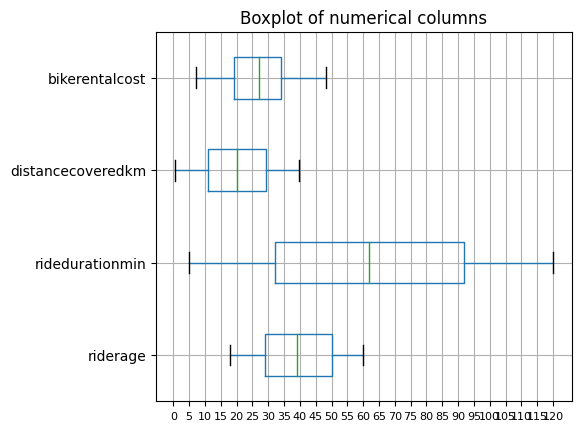

In [54]:
# using this example : https://stackoverflow.com/questions/18500011/horizontal-box-plots-in-matplotlib-pandas
df[numeric_columns].boxplot(vert=False)
plt.subplots_adjust(left=0.25)
plt.xticks(range(0, int(df[numeric_columns].max().max()) + 1, 5),fontsize=8)
plt.title("Boxplot of numerical columns")
plt.show()


In [13]:
# describing categorical variables
cleaned_df.describe(include='object')

,city,weathercondition,bikemodel,ridersatisfaction
count,853,853,853,853
unique,6,4,4,3
top,London,Rainy,Electric,High
freq,183,238,285,307


In [38]:
vale_counts_table = pd.DataFrame()
max_unique_vals = max(len(cleaned_df[[column]].value_counts()) for column in categorical_columns)

    
for column in categorical_columns:
    names =  [None for _ in range(max_unique_vals)]
    counts = [None for _ in range(max_unique_vals)]

    for idx,(name, value) in enumerate(cleaned_df[[column]].value_counts().items()):
        names[idx] = name[0]
        counts[idx] = value
    vale_counts_table[f"{column}_name"] = names
    vale_counts_table[f"{column}_count"] = counts



In [39]:
vale_counts_table.T

,0,1,2,3,4,5
city_name,London,Berlin,New York,Chicago,San Francisco,Dublin
city_count,183,163,163,160,159,25
weathercondition_name,Rainy,Sunny,Snowy,Cloudy,None,None
weathercondition_count,238.0,212.0,210.0,193.0,NaN,NaN
bikemodel_name,Electric,Mountain,Standard,Manual,None,None
bikemodel_count,285.0,285.0,282.0,1.0,NaN,NaN
ridersatisfaction_name,High,Medium,Low,None,None,None
ridersatisfaction_count,307.0,286.0,260.0,NaN,NaN,NaN


#### City is uniform in frequency except for dublin which has very few examples
#### Weather condition is pretty uniform as well, most frequent is rainy days
#### Bike model is uniform with only one example of "manual"
#### riderstisfaction is uniform, slightly more people are High satistifeid vs medium vs low

In [34]:
for column in categorical_columns:
    plt.figure(figsize=(12, 5))  # Set figure size
    df[column].value_counts().plot(kind='bar', color='skyblue')  # Plot bar chart
    plt.title(f'Histogram of {column}')  # Add title
    plt.xlabel(column)  # X-axis label
    plt.ylabel('Frequency')  # Y-axis label
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show the plot
    input()
    clear_output()

## Ideas to investigate
#### Are people overall satistified ?
#### People satisfaction is almost even between low, medium and high
#### What are the most profitables regions ?
#### What are the regions with higher and lower satisfcation ?
#### Do satisfied people pay more ? less ?


In [16]:
targets=['ridersatisfaction','bikerentalcost']
for col in targets:
    print(df[col].value_counts())


ridersatisfaction
High      319
Medium    299
Low       271
Name: count, dtype: int64
bikerentalcost
32.75    3
23.85    3
15.67    3
26.90    3
31.43    3
        ..
11.97    1
21.81    1
22.16    1
11.44    1
13.02    1
Name: count, Length: 786, dtype: int64


In [17]:
df['bikerentalcost'].describe()

count    891.000000
mean      26.581470
std        9.438224
min        7.330000
25%       19.210000
50%       27.040000
75%       33.955000
max       48.380000
Name: bikerentalcost, dtype: float64

In [18]:
df['bikerentalcost'].hist()

<Axes: >

In [19]:

ax = df[targets].plot.box()

In [20]:
df['ridersatisfaction'].value_counts()[['Low','Medium','High']].plot(kind='bar')

<Axes: xlabel='ridersatisfaction'>

In [21]:
df['ridersatisfaction'].value_counts()

ridersatisfaction
High      319
Medium    299
Low       271
Name: count, dtype: int64

## References

https://stackoverflow.com/questions/18500011/horizontal-box-plots-in-matplotlib-pandas